In [2]:
# base
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import Lasso

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

# tunning hyperparamters model
import optuna

from sklearn.feature_selection import f_regression, chi2

Загрузка и обьеденение датасета

In [3]:
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
all_data =pd.concat([X_train, X_test])
all_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,

Удаление нанов

In [4]:
cat_feat_nan = ['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
all_data[cat_feat_nan] = all_data[cat_feat_nan].fillna('without')


all_data['LotFrontage'] = all_data['LotFrontage'].fillna(0)
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['YearBuilt'])


mean_fill = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
mode_fill = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'SaleType']

all_data[mean_fill] = all_data[mean_fill].fillna(all_data[mean_fill].mode().iloc[0])
all_data[mode_fill] = all_data[mode_fill].fillna(all_data[mode_fill].mode().iloc[0])



print(all_data.isnull().sum()[all_data.isnull().sum() > 0])

SalePrice    1459
dtype: int64


Графики
распределение цен на дома (таргета)
сабплот с гистограмами числовых признаков
 сабплот с барплотами категориальных признаков
матрица корреляций

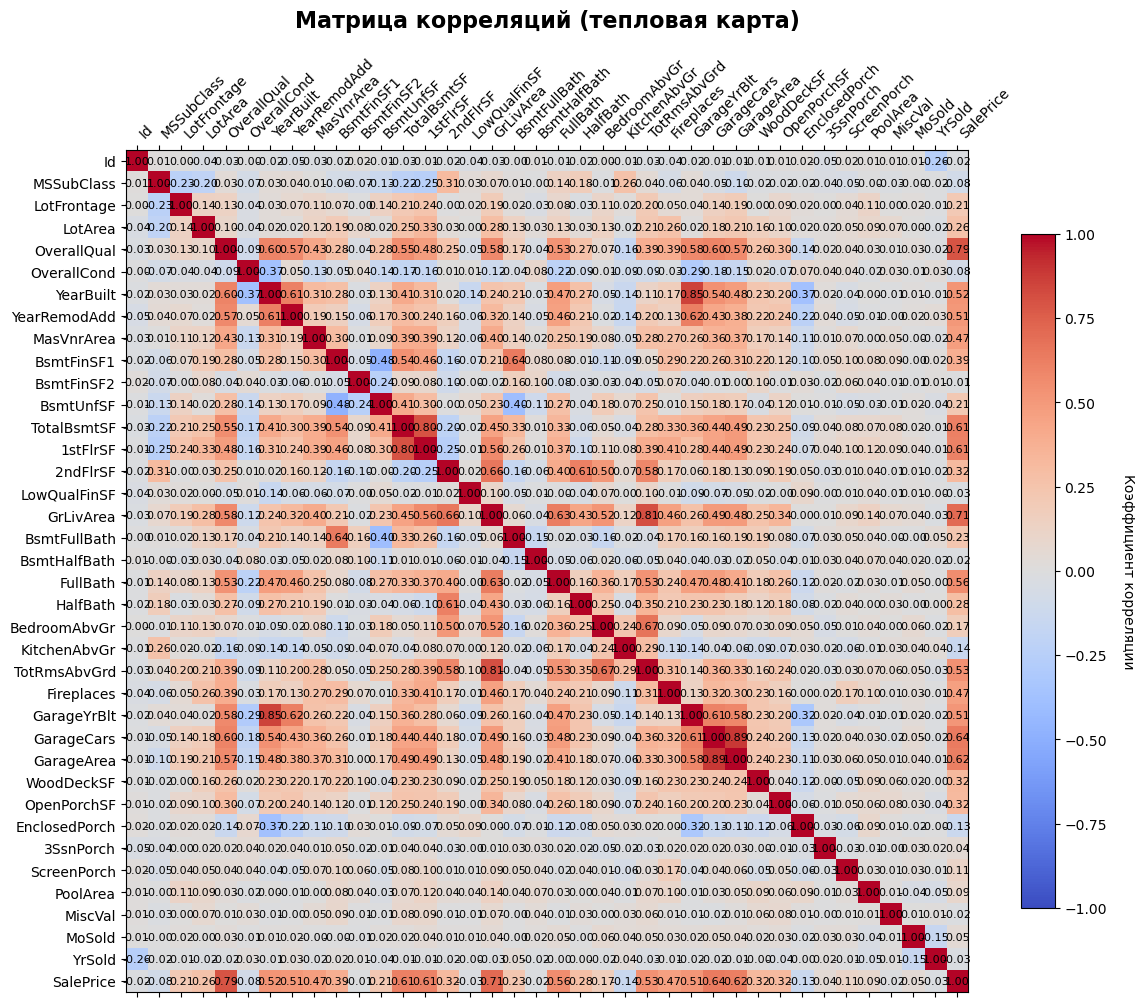

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Вычисляем корреляционную матрицу
corr_matrix = all_data.select_dtypes(include=[np.number]).corr()

# Создаём фигуру и оси
fig, ax = plt.subplots(figsize=(12, 10))


# Рисуем тепловую карту через matshow
im = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)


# Добавляем значения корреляций в ячейки
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', color='black', fontsize=8)


# Настраиваем метки
ax.set_xticks(range(corr_matrix.shape[1]))
ax.set_yticks(range(corr_matrix.shape[0]))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(corr_matrix.columns)


# Добавляем цветную шкалу (легенду)
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Коэффициент корреляции', rotation=270, labelpad=20)


# Заголовок
plt.title('Матрица корреляций (тепловая карта)', fontsize=16, fontweight='bold', pad=20)


# Улучшаем расположение элементов
plt.tight_layout()
plt.show()

Результат:
Overquality очень хорошо предсказывает таргет
Garageyearbuild на 85 проц повторяет Yearbuild
Total bsmtSF кандидат на выкид - колинеарный с площадьми первого этажа и пр
totalrmsabvgrd выкидываем так как отражает жилую площадь без подвала
Garage cars выкинуть отражает garage area


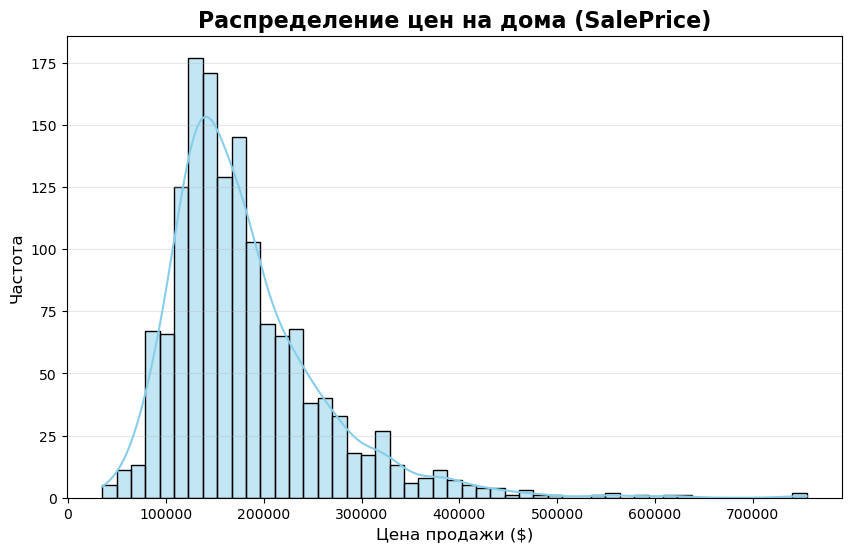

In [6]:
# Распределение целевой переменной (цены на дома)

plt.figure(figsize=(10, 6))
sns.histplot(all_data['SalePrice'], kde=True, color='skyblue')
plt.title('Распределение цен на дома (SalePrice)', fontsize=16, fontweight='bold')
plt.xlabel('Цена продажи ($)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

Распределение цен Точно есть выброс по цене выше 500 000  заменим на среднюю

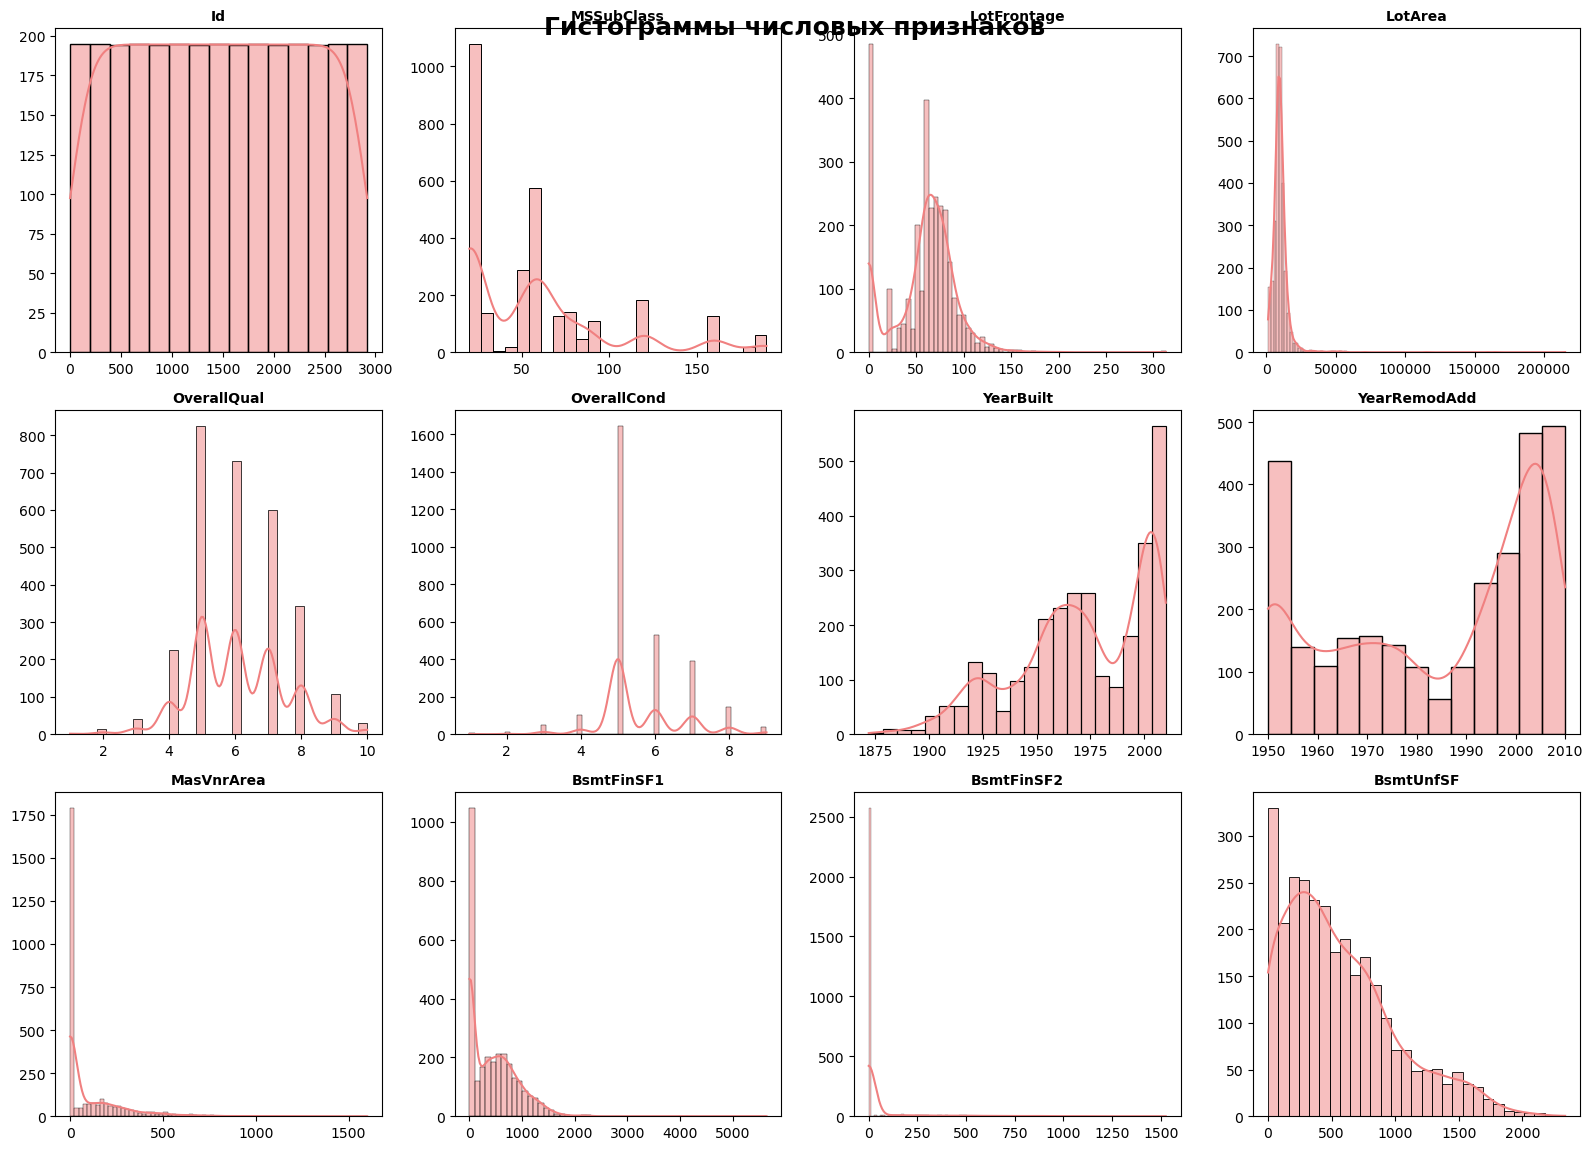

In [7]:
# Сабплот с гистограммами числовых признаков

# Выбираем числовые столбцы (исключая целевую переменную)
numeric_cols = all_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('SalePrice')  # убираем целевую переменную, если есть

# Ограничим число признаков для наглядности (например, первые 12)
numeric_cols = numeric_cols[:12]

# Создаём сабплот
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()  # превращаем матрицу осей в массив

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        sns.histplot(all_data[col].dropna(), ax=axes[i], color='lightcoral', kde=True)
        axes[i].set_title(f'{col}', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

# Удаляем пустые подграфики
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Гистограммы числовых признаков', fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()



lotfrontage мало влияет
lotarea рубим больше 50 000


/var/folders/dx/r5z899gx1h159s3rd8fm1jjw0000gn/T/ipykernel_60741/1174728688.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis')
/var/folders/dx/r5z899gx1h159s3rd8fm1jjw0000gn/T/ipykernel_60741/1174728688.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis')
/var/folders/dx/r5z899gx1h159s3rd8fm1jjw0000gn/T/ipykernel_60741/1174728688.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values,

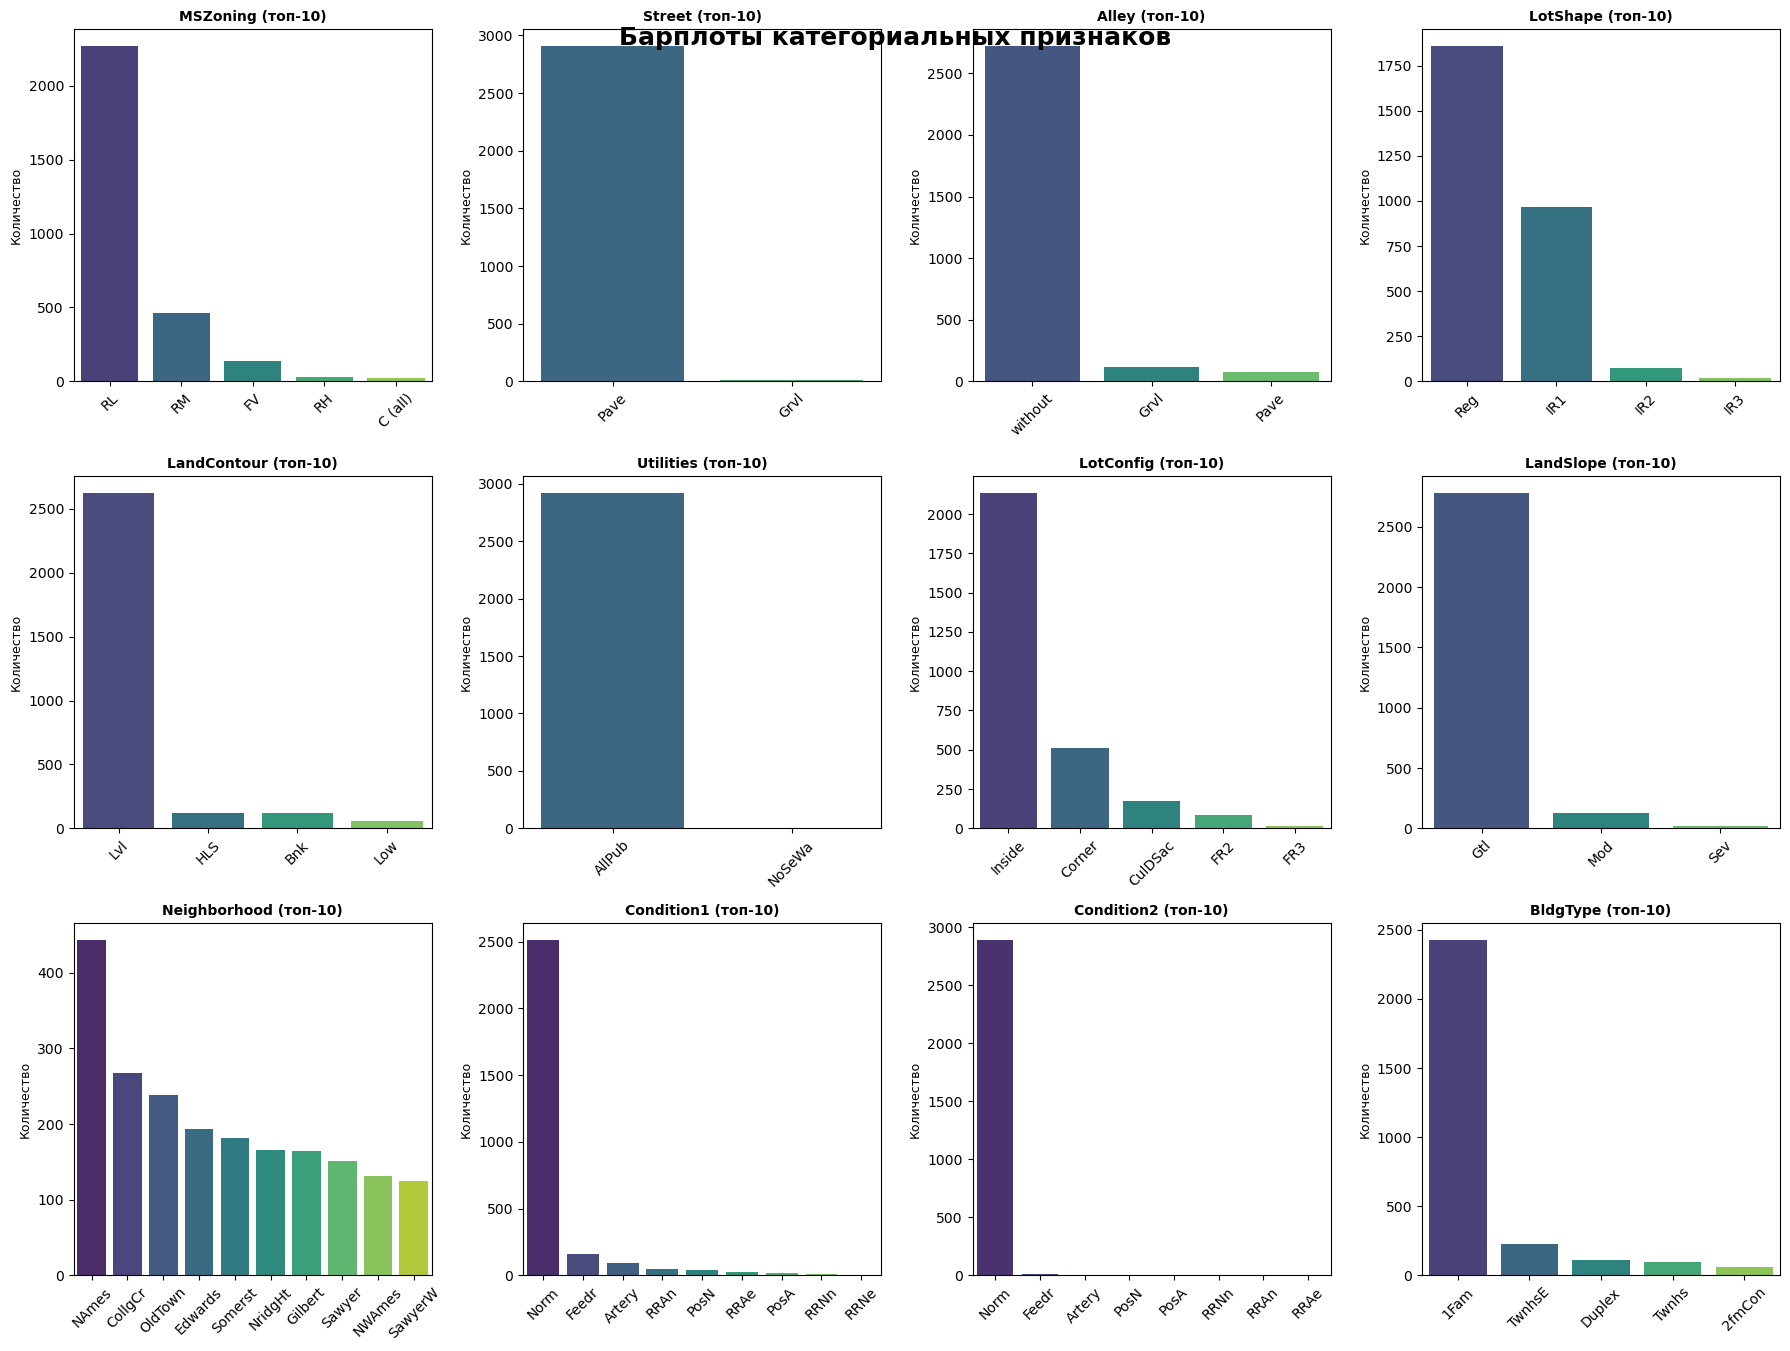

In [8]:
# Сабплот с барплотами категориальных признаков

# Выбираем категориальные столбцы
categorical_cols = all_data.select_dtypes(include=['object']).columns.tolist()

# Ограничим до 12 признаков для наглядности
categorical_cols = categorical_cols[:12]

# Создаём сабплот
fig, axes = plt.subplots(3, 4, figsize=(18, 14))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        # Считаем частоты категорий
        counts = all_data[col].value_counts().head(10)  # топ-10 категорий
        sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis')
        axes[i].set_title(f'{col} (топ-10)', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Количество', fontsize=9)
        axes[i].tick_params(axis='x', rotation=45)

# Удаляем пустые подграфики
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])


plt.suptitle('Барплоты категориальных признаков', fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

мало информации дает

Разделяем датасет

In [9]:
X_train = all_data.iloc[:1460]
y_train = X_train['SalePrice']
X_train = X_train.drop('SalePrice', axis=1)

X_valid = all_data.iloc[1460:].drop('SalePrice', axis=1)



Разделяем названия колонок на енкодеры

In [10]:
a = X_train.select_dtypes(include='object')
one_hot_coder = a.loc[:, a.nunique() <= 3].columns.to_list()
target_coder = a.loc[:, a.nunique() > 3 ].columns.to_list()



In [11]:
preprocessor = ColumnTransformer(
    [
        ('ohe_hot_coder', OneHotEncoder(sparse_output=False), one_hot_coder),
        ('target_coder', TargetEncoder(), target_coder),
        
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

model = LinearRegression()

ml1_pipeline = Pipeline(
    (
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)   
    )
)

y_train_log = np.log1p(y_train)


In [12]:
ml1_pipeline.fit(X_train, y_train_log)

,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ohe_hot_coder', ...), ('target_coder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [13]:
y_pred_log = ml1_pipeline.predict(X_valid)
y_pred =  np.expm1(y_pred_log)
y_pred

array([106645.99802045, 144667.75740835, 164083.70012542, ...,
       162806.88128839, 113957.89346352, 216167.87924539], shape=(1459,))

In [14]:


# Предсказание и обратное преобразование
y_pred = pd.Series(
    np.expm1(ml1_pipeline.predict(X_valid)),
    index=X_valid.index,
    name='SalePrice'
)

# Вывод первых 10 предсказаний
from sklearn.metrics import mean_squared_error

# Так как y_train_log = log1p(y_train), предсказания тоже в log1p-шкале
y_pred_log = ml1_pipeline.predict(X_train)

# RMSLE = RMSE на логарифмах
rmsle = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
print(f"RMSLE: {rmsle:.4f}")



RMSLE: 0.1246


In [15]:


y_pred = pd.Series(
    np.expm1(ml1_pipeline.predict(X_valid)),
    index=X_valid['Id'],  # ← используем реальные Id из данных
    name='SalePrice'
)

In [16]:
y_pred.to_csv('baseline_result.csv')

# Kagle 0.139

**Фильтрация фитч**

In [17]:
numeric_cols = all_data.select_dtypes(include=[np.number]).columns.tolist()
lst = all_data[numeric_cols].corr()['SalePrice'][:-1].sort_values(key=lambda x: abs(x), ascending=False)

cor_result = ['Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', 'MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF']

lst

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
GarageYrBlt      0.508043
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

In [18]:
# Выбираем числовые столбцы
numeric_cols = all_data.select_dtypes(include=[np.number])

# Отделяем признаки и целевую переменную
X = numeric_cols.drop(columns=['SalePrice'])
y = numeric_cols['SalePrice']

# Удаляем строки с пропусками (или заранее обработайте NaN!)
# Важно: f_regression не работает с NaN!
mask = ~(X.isna().any(axis=1) | y.isna())
X_clean = X.loc[mask]
y_clean = y.loc[mask]

# Вычисляем p-value для каждого признака
f_stats, p_values = f_regression(X_clean, y_clean)

# Создаём Series: признак -> p-value
pval_series = pd.Series(p_values, index=X.columns).sort_values()

print(pval_series.to_string())

res = ['MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']
   


OverallQual      2.185675e-313
GrLivArea        4.518034e-223
GarageCars       2.498644e-169
GarageArea       5.265038e-158
TotalBsmtSF      9.484229e-152
1stFlrSF         5.394711e-147
FullBath         1.236470e-121
TotRmsAbvGrd     2.772281e-108
YearBuilt        2.990229e-103
GarageYrBlt       1.234823e-96
YearRemodAdd      3.164948e-96
MasVnrArea        4.100461e-82
Fireplaces        6.141487e-80
BsmtFinSF1        3.394110e-53
WoodDeckSF        3.972217e-37
2ndFlrSF          5.764335e-36
OpenPorchSF       3.493374e-35
HalfBath          1.650473e-28
LotArea           1.123139e-24
BsmtFullBath      1.550344e-18
BsmtUnfSF         1.182976e-16
LotFrontage       5.824303e-16
BedroomAbvGr      9.927497e-11
KitchenAbvGr      1.860426e-07
EnclosedPorch     8.255770e-07
ScreenPorch       1.972140e-05
PoolArea          4.073490e-04
MSSubClass        1.266472e-03
OverallCond       2.912351e-03
MoSold            7.612758e-02
3SsnPorch         8.858170e-02
YrSold            2.694132e-01
LowQualF

In [19]:



preprocessor = ColumnTransformer(
    [
        ('ohe_hot_coder', OneHotEncoder(sparse_output=False), one_hot_coder),
        ('target_coder', TargetEncoder(), target_coder),
        
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)

ml2_pipeline = Pipeline(
    (
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)   
    )
)

y_train_log = np.log1p(y_train)


ml2_pipeline.fit(X_train, y_train_log)



# Предсказание и обратное преобразование
y_pred = pd.Series(
    np.expm1(ml1_pipeline.predict(X_valid)),
    index=X_valid.index,
    name='SalePrice'
)

# Вывод первых 10 предсказаний
from sklearn.metrics import mean_squared_error

# Так как y_train_log = log1p(y_train), предсказания тоже в log1p-шкале
y_pred_log = ml1_pipeline.predict(X_train)

# RMSLE = RMSE на логарифмах
rmsle = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
print(f"RMSLE: {rmsle:.4f}")


0:	learn: 0.3742090	total: 62.6ms	remaining: 18.7s
1:	learn: 0.3498073	total: 64.8ms	remaining: 9.65s
2:	learn: 0.3279895	total: 66.5ms	remaining: 6.59s
3:	learn: 0.3081299	total: 68.3ms	remaining: 5.06s
4:	learn: 0.2911823	total: 70.2ms	remaining: 4.14s
5:	learn: 0.2745484	total: 71.9ms	remaining: 3.52s
6:	learn: 0.2601501	total: 73.6ms	remaining: 3.08s
7:	learn: 0.2465827	total: 75.3ms	remaining: 2.75s
8:	learn: 0.2346372	total: 76.9ms	remaining: 2.49s
9:	learn: 0.2238130	total: 78.5ms	remaining: 2.28s
10:	learn: 0.2140489	total: 80.1ms	remaining: 2.1s
11:	learn: 0.2052352	total: 81.6ms	remaining: 1.96s
12:	learn: 0.1974107	total: 83.1ms	remaining: 1.83s
13:	learn: 0.1900000	total: 84.7ms	remaining: 1.73s
14:	learn: 0.1828183	total: 86.2ms	remaining: 1.64s
15:	learn: 0.1767854	total: 87.7ms	remaining: 1.56s
16:	learn: 0.1709399	total: 89.2ms	remaining: 1.49s
17:	learn: 0.1663955	total: 90.7ms	remaining: 1.42s
18:	learn: 0.1625592	total: 92.3ms	remaining: 1.36s
19:	learn: 0.1591582	to

In [20]:

X_num = X_train.select_dtypes(include=[np.number])
y_num = y_train


lasso = Lasso(alpha= 0.4)
lasso.fit(X_num, y_num)


pd.Series(dict(zip(X_num.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)

res = ['OpenPorchSF', 'Id', 'MiscVal', 'LotArea', 'GarageArea']


In [21]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_num, y_num, verbose=False, plot=False)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_num)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_num.iloc[0,:])




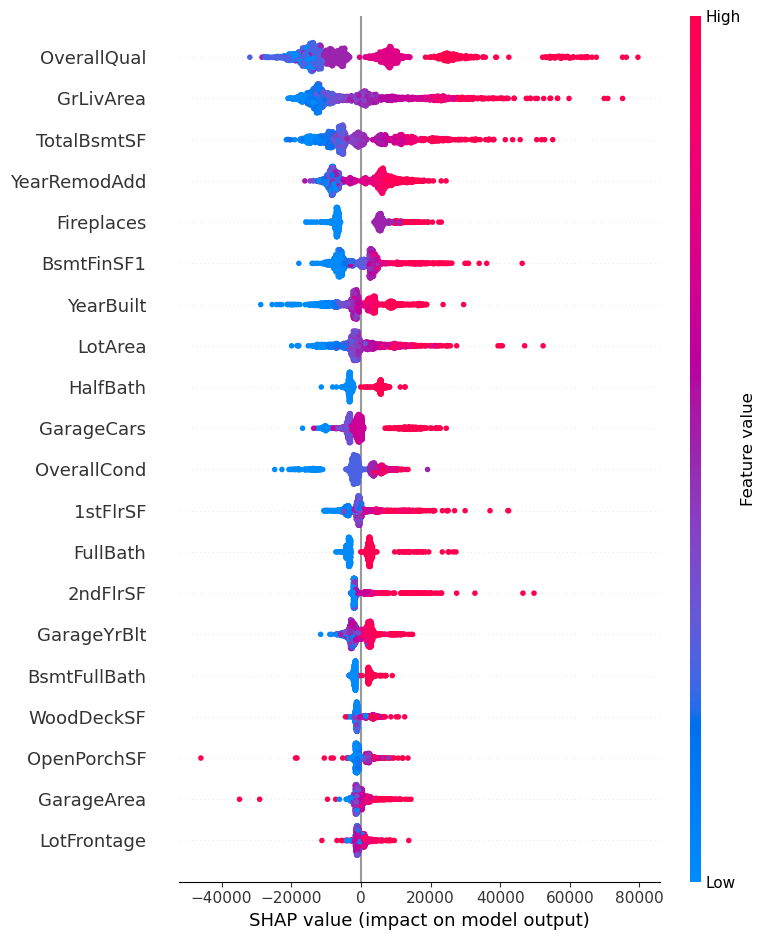

In [22]:
shap.summary_plot(shap_values, X_num)

In [23]:
res = ['BsmtFullBath', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath']

Garagearea проверить на выброс

In [24]:
cor_result = ['Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', 'MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF']
cor_result = set(cor_result)
res1 = ['MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']
res1 = set(res1)

res2 = ['OpenPorchSF', 'Id', 'MiscVal', 'LotArea', 'GarageArea']
res2 = set(res2)

res3 = ['BsmtFullBath', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath']
res3 = set(res3)

fromcor = ['GarageCars', 'totalrmsabvgrd', 'Total bsmtSF', 'Garageyearbuild']
fromcor = set(fromcor)
union = cor_result.union(res1, res2, res3, fromcor)
union

{'3SsnPorch',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageArea',
 'GarageCars',
 'Garageyearbuild',
 'HalfBath',
 'Id',
 'LotArea',
 'LowQualFinSF',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'Total bsmtSF',
 'WoodDeckSF',
 'YrSold',
 'totalrmsabvgrd'}

In [25]:
X_valid

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,without,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,without,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,without,MnPrv,without,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,without,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,without,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,without,without,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,without,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,without,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,without,MnPrv,without,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,without,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,without,without,without,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,without,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,without,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,without,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,without,without,without,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,without,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,without,without,1970.0,without,0.0,0.0,without,without,Y,0,0,0,0,0,0,without,without,without,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,without,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,without,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,without,without,without,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,without,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,4

In [26]:
X_train['HouseAge'] = 2020 - X_train['YearBuilt']
X_valid['HouseAge'] = 2020 - X_valid['YearBuilt']
X_train['RemodAge'] = 2020 - X_train['YearRemodAdd']
X_valid['RemodAge'] = 2020 - X_valid['YearRemodAdd']

# 1. РЕМОНТ
X_train['IsOldNotRemod'] = ((X_train['HouseAge'] > 50) &
                              (X_train['RemodAge'] == X_train['HouseAge'])).astype(int)
X_valid['IsOldNotRemod'] = ((X_valid['HouseAge'] > 50) &
                            (X_valid['RemodAge'] == X_valid['HouseAge'])).astype(int)

# Качество × площадь = OverallQual × GrLivArea.

# 11. РАЗНИЦА КАЧЕСТВА И СОСТОЯНИЯ
X_train['QualCondDiff'] = X_train['OverallQual'] - X_train['OverallCond']
X_valid['QualCondDiff'] = X_valid['OverallQual'] - X_valid['OverallCond']

# 12. ЕСТЬ ГАРАЖ (бинарная фича)
X_train['HasGarage'] = (X_train['GarageArea'] > 0).astype(int)
X_valid['HasGarage'] = (X_valid['GarageArea'] > 0).astype(int)

# 13. ЕСТЬ ПОДВАЛ
X_train['HasBsmt'] = (X_train['TotalBsmtSF'] > 0).astype(int)
X_valid['HasBsmt'] = (X_valid['TotalBsmtSF'] > 0).astype(int)


# 14. ПЛОЩАДЬ УЧАСТКА НА ПЛОЩАДЬ ДОМА
X_train['LotRatio'] = X_train['LotArea'] / X_train['GrLivArea']
X_valid['LotRatio'] = X_valid['LotArea'] / X_valid['GrLivArea']
X_train['LotRatio'] = X_train['LotRatio'].replace([np.inf, -np.inf], 0)
X_valid['LotRatio'] = X_valid['LotRatio'].replace([np.inf, -np.inf], 0)

In [27]:
X_valid

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HouseAge,RemodAge,IsOldNotRemod,QualCondDiff,HasGarage,HasBsmt,LotRatio
0,1461,20,RH,80.0,11622,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,without,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,without,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,without,MnPrv,without,0,6,2010,WD,Normal,59,59,1,-1,1,1,12.970982
1,1462,20,RL,81.0,14267,Pave,without,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,without,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,without,without,Gar2,12500,6,2010,WD,Normal,62,62,1,0,1,1,10.735139
2,1463,60,RL,74.0,13830,Pave,without,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,without,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,without,MnPrv,without,0,3,2010,WD,Normal,23,22,0,0,1,1,8.489871
3,1464,60,RL,78.0,9978,Pave,without,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,without,without,without,0,6,2010,WD,Normal,22,22,0,0,1,1,6.220698
4,1465,120,RL,43.0,5005,Pave,without,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,without,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,without,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,without,without,without,0,1,2010,WD,Normal,28,28,0,3,1,1,3.910156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,without,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,without,without,1970.0,without,0.0,0.0,without,without,Y,0,0,0,0,0,0,without,without,without,0,6,2006,WD,Normal,50,50,0,-3,0,1,1.772894
1455,2916,160,RM,21.0,1894,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,without,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,without,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,without,without,without,0,4,2006,WD,Abnorml,50,50,0,-1,1,1,1.734432
1456,2917,20,RL,160.0,20000,Pave,wit

In [28]:
# cols_to_drop = ['3SsnPorch', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath',
#     'GarageCars', 'GarageYrBlt', 'HalfBath', 'LowQualFinSF',
#     'MiscVal', 'MoSold', 'OpenPorchSF', 'TotalBsmtSF',
#     'WoodDeckSF', 'YrSold', 'TotRmsAbvGrd']
# X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
# X_valid = X_valid.drop(columns=cols_to_drop, errors='ignore')
# if 'SalePrice' in X_train.columns:
#     sale_price_mean = X_train['SalePrice'].mean()
#     X_train.loc[X_train['SalePrice'] > 500000, 'SalePrice'] = sale_price_mean
# X_train.loc[X_train['LotArea'] > 500000, 'LotArea'] = 500000
# X_valid.loc[X_valid['LotArea'] > 500000, 'LotArea'] = 500000
# print(X_train.shape)
# print(X_valid.shape)
# print(cols_to_drop)

In [29]:
cat_f = X_train.select_dtypes(include='object').columns
id = [X_train.columns.get_loc(col) for col in cat_f]
id

[2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 39,
 40,
 41,
 42,
 53,
 55,
 57,
 58,
 60,
 63,
 64,
 65,
 72,
 73,
 74,
 78,
 79]

In [48]:


# preprocessor = ColumnTransformer(
#     [
#         ('ohe_hot_coder', OneHotEncoder(sparse_output=False), one_hot_coder),
#         ('target_coder', TargetEncoder(), target_coder),
        
#     ],
#     verbose_feature_names_out = False,
#     remainder = 'passthrough'
# )

model = CatBoostRegressor(iterations=1500, learning_rate=0.05, depth=6, l2_leaf_reg=8, random_seed=42, early_stopping_rounds=50, verbose=0, cat_features=id)



ml2_pipeline = Pipeline(
    [
        ('model', model)   
    ]
)

y_train_log = np.log1p(y_train)



In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split


preprocessor = ColumnTransformer(
    [
        ('ohe_hot_coder', OneHotEncoder(sparse_output=False), one_hot_coder),
        ('target_coder', TargetEncoder(), target_coder),
        
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)



base_models = [
    ('catboost', CatBoostRegressor(iterations=300, verbose=0, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=300, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42))]
meta_model = Ridge(alpha=1.0)

stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,                # кросс-валидация для генерации OOF-предсказаний
    n_jobs=-1,
    passthrough=False    # если True — добавит исходные признаки к предсказаниям базовых моделей
)

ml_stack_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('stack', stacking_regressor)
    ]
)

In [46]:
ml_stack_pipe.fit(X_train, y_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4824
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 90
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4522
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 90
[LightGBM] [Info] Start training from score 12.021897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

,steps,"[('preprocessor', ...), ('stack', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ohe_hot_coder', ...), ('target_coder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [33]:
# Предсказание и обратное преобразование

# Вывод первых 10 предсказаний
from sklearn.metrics import mean_squared_error

# Так как y_train_log = log1p(y_train), предсказания тоже в log1p-шкале
y_pred_log = ml_stack_pipe.predict(X_train)

# RMSLE = RMSE на логарифмах
rmsle = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 0.0485


/opt/anaconda3/envs/catboost_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [34]:
y_pred_log = ml_stack_pipe.predict(X_valid)

/opt/anaconda3/envs/catboost_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [35]:
y_pred = np.expm1(y_pred_log)


y_pred = pd.Series(
    y_pred,
    index=range(1461,2920),  # ← используем реальные Id из данных
    name='SalePrice')
y_pred.index.name = 'Id'
y_pred

Id
1461    123241.567320
1462    161923.272436
1463    188048.189760
1464    195696.420845
1465    189507.341351
            ...      
2915     79301.216515
2916     85271.938763
2917    161184.770570
2918    112520.422617
2919    217741.642138
Name: SalePrice, Length: 1459, dtype: float64

In [36]:
y_pred.to_csv('res2.csv')

**Single Catboost**

In [37]:
# def objective(trial):
#     # 1. Определите категориальные признаки
#     cat_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
    
#     # 2. Преобразуйте числовые столбцы, заменив нечисловые на NaN
#     X_tr_clean = X_train.copy()
    
#     for col in X_tr_clean.columns:
#         if col not in cat_features:
#             X_tr_clean[col] = pd.to_numeric(X_tr_clean[col], errors='coerce')
    
#     # Разделите данные
#     from sklearn.model_selection import train_test_split
#     X_tr, X_val, y_tr, y_val = train_test_split(
#         X_tr_clean, y_train, test_size=0.2, random_state=42
#     )

#     # 3. Подбирайте параметры
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
#         'random_strength': trial.suggest_float('random_strength', 1e-2, 10.0, log=True),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
#         'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 25),
#     }
#     if params['grow_policy'] == 'Lossguide':
#         params['max_leaves'] = trial.suggest_int('max_leaves', 10, 64)

#     # 4. Создайте модель с cat_features
#     model = CatBoostRegressor(
#         **params,
#         loss_function='RMSE',
#         eval_metric='RMSE',
#         verbose=0,
#         random_seed=42,
#         allow_writing_files=False,
#         cat_features=cat_features  # <-- укажите категориальные столбцы
#     )

#     # 5. Обучение
#     model.fit(
#         X_tr, y_tr,
#         eval_set=(X_val, np.log1p(y_val)),
#         early_stopping_rounds=50,
#         verbose=False
#     )

#     y_pred = model.predict(X_val)
#     rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(y_pred)))
#     return rmsle


# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)
# best_params = study.best_params
# best_value = study.best_value
# print(f"Лучшие параметры: {best_params}")
# print(f"Лучшее значение: {best_value}")

In [38]:
ml2_pipeline.fit(X_train, y_train_log)




,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False


In [39]:
# Предсказание и обратное преобразование

# Вывод первых 10 предсказаний
from sklearn.metrics import mean_squared_error

# Так как y_train_log = log1p(y_train), предсказания тоже в log1p-шкале
y_pred_log = ml2_pipeline.predict(X_train)

# RMSLE = RMSE на логарифмах
rmsle = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 0.0631


In [40]:
X_valid

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HouseAge,RemodAge,IsOldNotRemod,QualCondDiff,HasGarage,HasBsmt,LotRatio
0,1461,20,RH,80.0,11622,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,without,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,without,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,without,MnPrv,without,0,6,2010,WD,Normal,59,59,1,-1,1,1,12.970982
1,1462,20,RL,81.0,14267,Pave,without,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,without,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,without,without,Gar2,12500,6,2010,WD,Normal,62,62,1,0,1,1,10.735139
2,1463,60,RL,74.0,13830,Pave,without,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,without,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,without,MnPrv,without,0,3,2010,WD,Normal,23,22,0,0,1,1,8.489871
3,1464,60,RL,78.0,9978,Pave,without,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,without,without,without,0,6,2010,WD,Normal,22,22,0,0,1,1,6.220698
4,1465,120,RL,43.0,5005,Pave,without,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,without,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,without,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,without,without,without,0,1,2010,WD,Normal,28,28,0,3,1,1,3.910156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,without,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,without,without,1970.0,without,0.0,0.0,without,without,Y,0,0,0,0,0,0,without,without,without,0,6,2006,WD,Normal,50,50,0,-3,0,1,1.772894
1455,2916,160,RM,21.0,1894,Pave,without,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,without,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,without,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,without,without,without,0,4,2006,WD,Abnorml,50,50,0,-1,1,1,1.734432
1456,2917,20,RL,160.0,20000,Pave,wit

In [41]:
y_pred_log = ml2_pipeline.predict(X_valid)

In [42]:
y_pred = np.expm1(y_pred_log)


y_pred = pd.Series(
    y_pred,
    index=range(1461,2920),  # ← используем реальные Id из данных
    name='SalePrice')
y_pred.index.name = 'Id'

In [43]:
y_pred.to_csv('res1.csv')